# **Eco-Risk Alpha: Measuring the Green Discount in Counterparty CVA**

## **Objective**

The project centers on a portfolio of interest-rate swaps (IRS). Your mission is to build statistical and
machine learning models that explain credit-default-swap (CDS) spreads using ESG and fundamental risk factor variables. You will then translate those spreads into CVA numbers to quantify a potential ”green
credit premium”.

## **Case Study Problem**

Banks quote and hedge CVA to cover expected losses from counterparty default. If greener companies genuinely default less or trade tighter in credit markets, a dealer can lower its CVA charges by selecting such
counterparties.
However the empirical evidence is mixed: some studies suggest a measurable ”ESG discount”, whereas others
argue that credit markets already price sustainability metrics.
Your task is to test this hypothesis by:
- Linking ESG scores to observed CDS spreads
- Converting both market and model-implied spreads into default intensities
- Computing Unilateral CVA for a benchmark swap exposure
- Comparing actual vs. ESG-implied CVA to derive a ”green-premium” measure

## **Case Study Core Tasks**

You will work through a structured sequence of tasks designed to simulate the workflow of a quant on a
trading desk. Each task builds on the previous one, combining financial insight with data science techniques.
1. **Data exploration and cleaning**: Visualize CDS vs. ESG, identify and handle outliers (if necessary),
missing values and check for duplicates
2. **Baseline linear model**: Regress CDS spread on ESG scores and some dummies (up to you to choose
which)
3. **Factor selection rationale**: Justify your variable choices to isolate the ESG effect
4. **CVA computation**: Convert actual and model-predicted spreads to hazard rates, then apply the unilateral CVA formula using the provided EE profile
5. **Machine learning model**: Train a model (ideally a model where you can explain the importance of the
variables in your results, e.g.: Random Forest or Gradient Boosting) to predict CDS spreads (you are
free to choose the features based on your own feature selection rationale) and compute CVA
6. **Machine learning mode**: Compare CVA actual vs. CVA predicted (from both models), bucket firms by ESG
tertile, and interpret the economic significance of the green premium





# **Setup**

## Working Directory

In [6]:
from pathlib import Path

base_dir = Path.cwd()       
data_dir = base_dir / "data"


## Dependencies

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import IsolationForest
from scipy import stats
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import LeaveOneOut, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
!pip install mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from scipy.stats import randint


## Reproducibility

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


## Constants

In [ ]:
LGD = 0.6
RECOVERY = 1 - LGD


## Upload Data

In [ ]:
companies_df = pd.read_csv(os.path.join(base_drive_dir, 'Data/raw_companies_data.csv'))
ee_df = pd.read_csv(os.path.join(base_drive_dir, 'Data/synthetic_irs_ee_profile.csv'))
zeros_df = pd.read_csv(os.path.join(base_drive_dir, 'Data/zero_rates.csv'))


# **Data exploration and cleaning**

## Show data

In [ ]:
print(companies_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        60 non-null     int64  
 1   Company           60 non-null     object 
 2   Sector            60 non-null     object 
 3   Region            60 non-null     object 
 4   ESG_Score         54 non-null     float64
 5   E_Score           60 non-null     float64
 6   S_Score           60 non-null     float64
 7   G_Score           60 non-null     float64
 8   Carbon_Intensity  52 non-null     float64
 9   Market_Cap        53 non-null     float64
 10  Total_Assets      59 non-null     float64
 11  Debt_to_Equity    59 non-null     float64
 12  EBITDA_Margin     59 non-null     float64
 13  Leverage_Ratio    59 non-null     float64
 14  CDS_Spread_5Y     59 non-null     float64
dtypes: float64(11), int64(1), object(3)
memory usage: 7.2+ KB
None


In [ ]:
companies_df.head()


,Unnamed: 0,Company,Sector,Region,ESG_Score,E_Score,S_Score,G_Score,Carbon_Intensity,Market_Cap,Total_Assets,Debt_to_Equity,EBITDA_Margin,Leverage_Ratio,CDS_Spread_5Y
0,1,Company_1,technology,North America,52.4724,88.1751,31.8858,84.4960,NaN,30150.4403,12232.9808,1.5591,8.6093,1.5766,34.0068
1,2,Company_2,technology,North America,52.4724,88.1751,31.8858,84.4960,NaN,30150.4403,12232.9808,1.5591,8.6093,1.5766,34.0068
2,3,Company_3,Consumer Goods,north america,87.0429,76.5080,68.1846,44.3737,71.0350,39124.6751,107208.2171,2.5838,36.5894,1.1610,38.1718
3,4,Company_4,FINANCE,Europe,73.9196,86.3699,48.8614,38.6937,90.4072,85262.5305,109045.7541,2.0102,22.6838,0.9060,61.7321
4,5,Company_5,Technology,ASIA,65.9195,83.6896,60.5142,59.3672,274.6385,32375.2785,128211.1205,0.5725,33.9260,1.8221,29.9490


In [ ]:
companies_df.describe()


,Unnamed: 0,ESG_Score,E_Score,S_Score,G_Score,Carbon_Intensity,Market_Cap,Total_Assets,Debt_to_Equity,EBITDA_Margin,Leverage_Ratio,CDS_Spread_5Y
count,60.000000,54.000000,60.000000,60.000000,60.000000,52.000000,53.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,30.500000,57.914019,58.802118,56.639408,62.468137,216.242906,64191.576042,86954.479015,1.631280,21.073603,1.123024,34.238417
std,17.464249,16.748522,18.604903,18.412452,17.356465,188.244835,91289.452092,53289.909089,0.863179,11.382240,0.627700,18.291079
min,1.000000,32.063300,30.331300,30.417100,30.995300,51.265400,4019.524700,4849.910700,0.152800,5.379300,0.121600,4.720900
25%,15.750000,43.436925,41.881925,42.793425,44.520250,103.119900,22366.281700,51050.735900,0.917650,8.574300,0.575900,18.919300
50%,30.500000,56.886650,56.992700,53.220400,66.695950,197.916650,51622.897500,85080.812400,1.768900,18.622100,1.152300,29.887100
75%,45.250000,72.126800,76.262550,72.969100,76.792500,262.542525,79783.474300,126834.403100,2.319900,31.510550,1.791500,48.224450
max,60.000000,88.194600,89.213200,88.306900,89.139000,1038.923300,523146.355800,195218.711700,2.972500,39.532400,1.986600,72.005700


## Drop uninformative columns

In [ ]:
# Drop useless columns
companies_df_clean = companies_df.copy()
companies_df_clean.drop(columns=['Unnamed: 0', 'Company'], inplace=True)


## Uniform Sector and Region names

In [ ]:
# Sector
print(companies_df_clean['Sector'].unique())
companies_df_clean['Sector'] = companies_df_clean['Sector'].str.title()
companies_df_clean['Sector'] = companies_df_clean['Sector'].replace('Tech', 'Technology')
print(companies_df_clean['Sector'].unique())

# Region
print(companies_df_clean['Region'].unique())
companies_df_clean['Region'] = companies_df_clean['Region'].str.title()
print(companies_df_clean['Region'].unique())

['technology' 'Consumer Goods' 'FINANCE' 'Technology' 'Utilities'
 'Finance' 'Healthcare' 'Industrials' 'Energy' 'Tech']
['Technology' 'Consumer Goods' 'Finance' 'Utilities' 'Healthcare'
 'Industrials' 'Energy']
['North America' 'north america' 'Europe' 'ASIA' 'South America' 'Asia']
['North America' 'Europe' 'Asia' 'South America']


## Check and Drop duplicate entries

In [ ]:
# Check duplicate rows
dup_rows = companies_df_clean.duplicated().sum()
print(f"Duplicate rows: {dup_rows}")
if dup_rows > 0:
    display(companies_df_clean[companies_df_clean.duplicated(keep=False)])

# Remove duplicate rows, keeping the first occurrence
companies_df_clean = companies_df_clean.drop_duplicates(keep='first').reset_index(drop=True)
print(f"Shape before: {companies_df.shape}, after removing duplicates: {companies_df_clean.shape}")


Duplicate rows: 9


,Sector,Region,ESG_Score,E_Score,S_Score,G_Score,Carbon_Intensity,Market_Cap,Total_Assets,Debt_to_Equity,EBITDA_Margin,Leverage_Ratio,CDS_Spread_5Y
0,Technology,North America,52.4724,88.1751,31.8858,84.4960,NaN,30150.4403,12232.9808,1.5591,8.6093,1.5766,34.0068
1,Technology,North America,52.4724,88.1751,31.8858,84.4960,NaN,30150.4403,12232.9808,1.5591,8.6093,1.5766,34.0068
10,Utilities,Europe,72.4844,49.5198,34.6188,73.6930,90.2020,10620.4729,55624.7857,1.7689,8.1950,0.3258,29.8871
11,Utilities,Europe,72.4844,49.5198,34.6188,73.6930,90.2020,10620.4729,55624.7857,1.7689,8.1950,0.3258,29.8871
12,Utilities,Europe,72.4844,49.5198,34.6188,73.6930,90.2020,10620.4729,55624.7857,1.7689,8.1950,0.3258,29.8871
13,Utilities,Europe,72.4844,49.5198,34.6188,73.6930,90.2020,10620.4729,55624.7857,1.7689,8.1950,0.3258,29.8871
24,Consumer Goods,North America,47.4737,89.2132,62.3605,65.4536,262.3059,30065.5926,51548.0938,0.3011,31.3331,1.9301,54.0745
25,Consumer Goods,North America,47.4737,89.2132,62.3605,65.4536,262.3059,30065.5926,51548.0938,0.3011,31.3331,1.9301,54.0745
35,Consumer Goods,South America,32.7870,36.9521,60.6448,38.2513,1038.9233,79783.4743,51050.7359,0.9174,9.0973,1.0939,13.4173
36,Consumer Goods,South America,32.7870,36.9521,60.6448,38.2513,1038.9233,79783.4743,51050.7359,0.9174,9.0973,1.0939,13.4173


Shape before: (60, 15), after removing duplicates: (51, 13)


## Compute missing ESG from E,S,G pillars

In [ ]:
# Compute ESG from pillars
mask = companies_df_clean['ESG_Score'].isnull()
companies_df_clean.loc[mask, 'ESG_Score'] = (
    0.5 * companies_df_clean.loc[mask, 'E_Score'] +
    0.3 * companies_df_clean.loc[mask, 'S_Score'] +
    0.2 * companies_df_clean.loc[mask, 'G_Score']
)

# Remove E,S,G pillars from database
companies_df_clean = companies_df_clean.drop(columns=['E_Score', 'S_Score', 'G_Score'])
print(companies_df_clean.shape)


(51, 10)


## Check and Replace missing values

In [ ]:
# Check missing values
missing_summary = companies_df_clean.isnull().sum().sort_values(ascending=False)
print("\nMissing values per column:")
print(missing_summary)



Missing values per column:
Market_Cap          6
Carbon_Intensity    6
Leverage_Ratio      1
EBITDA_Margin       1
Total_Assets        1
Debt_to_Equity      1
CDS_Spread_5Y       1
Sector              0
Region              0
ESG_Score           0
dtype: int64



Missing values per column:
Sector              0
Region              0
ESG_Score           0
Carbon_Intensity    0
Total_Assets        0
Debt_to_Equity      0
EBITDA_Margin       0
Leverage_Ratio      0
CDS_Spread_5Y       0
dtype: int64


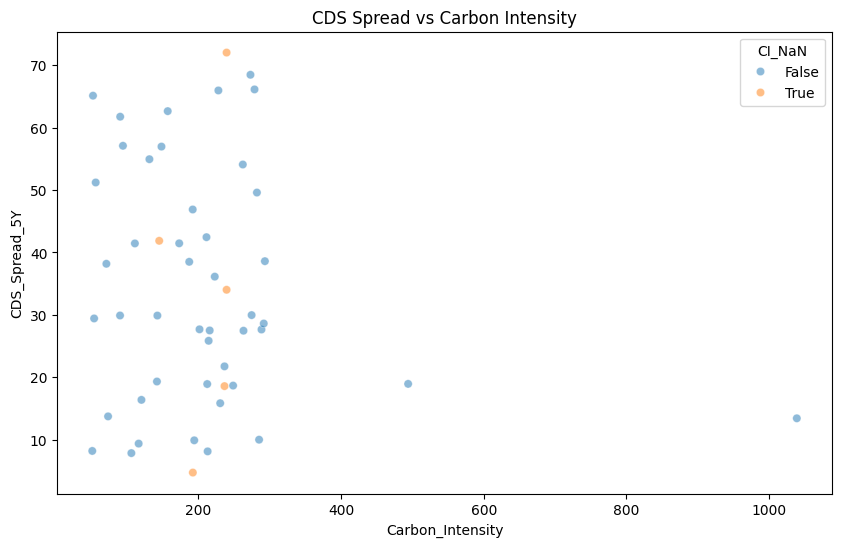

In [ ]:
# Delete Market Cap
companies_df_clean = companies_df_clean.drop(columns=['Market_Cap'])

# Delete row 16 (too much NaNs)
companies_df_clean = companies_df_clean.drop(index=16).reset_index(drop=True)

# Flag missing Carbon Intensity
companies_df_clean['CI_NaN'] = companies_df_clean['Carbon_Intensity'].isnull()

# Sector-wise median imputation for Carbon Intensity
companies_df_clean['Carbon_Intensity'] = companies_df_clean.groupby('Sector')['Carbon_Intensity'].transform(lambda x: x.fillna(x.median()))

# Plot Carbon Intesity with flags vs other features
plt.figure(figsize=(10, 6))
sns.scatterplot(data=companies_df_clean, x='Carbon_Intensity', y='CDS_Spread_5Y', hue='CI_NaN', alpha=0.5)
plt.title("CDS Spread vs Carbon Intensity")

# Remove flag from df
companies_df_clean = companies_df_clean.drop(columns=['CI_NaN'])

# Check missing values again
missing_summary = companies_df_clean.isnull().sum().sort_values(ascending=False)
print("\nMissing values per column:")
print(missing_summary)

In [ ]:
display(companies_df_clean.describe())

,ESG_Score,Carbon_Intensity,Total_Assets,Debt_to_Equity,EBITDA_Margin,Leverage_Ratio,CDS_Spread_5Y
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,58.757185,207.367339,92502.867390,1.623114,22.715582,1.099274,34.050634
std,16.780137,147.549641,54616.216749,0.896334,11.177108,0.609494,19.109529
min,32.063300,51.265400,4849.910700,0.152800,5.379300,0.121600,4.720900
25%,46.013525,122.982300,51175.075375,0.917525,11.319125,0.628700,18.719075
50%,58.537400,206.487700,95816.914400,1.783800,22.494250,1.127450,29.880700
75%,71.756600,246.418075,131592.090575,2.410475,32.688125,1.706875,48.902275
max,88.194600,1038.923300,195218.711700,2.972500,39.532400,1.986600,72.005700


## Visualize data


CDS Spread stats (bps):
count    59.000000
mean     34.238417
std      18.291079
min       4.720900
25%      18.919300
50%      29.887100
75%      48.224450
max      72.005700
Name: CDS_Spread_5Y, dtype: float64

ESG Score stats:
count    54.000000
mean     57.914019
std      16.748522
min      32.063300
25%      43.436925
50%      56.886650
75%      72.126800
max      88.194600
Name: ESG_Score, dtype: float64


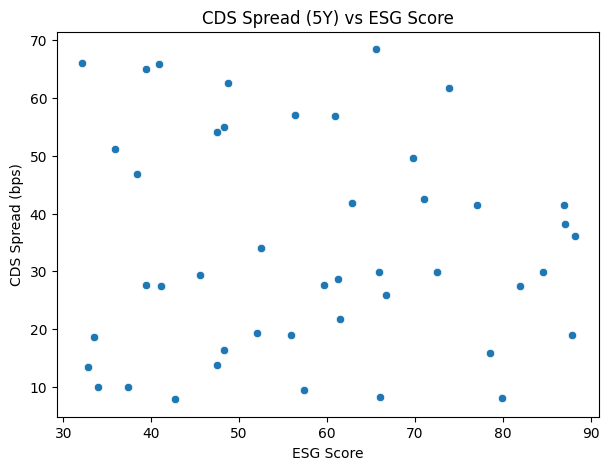

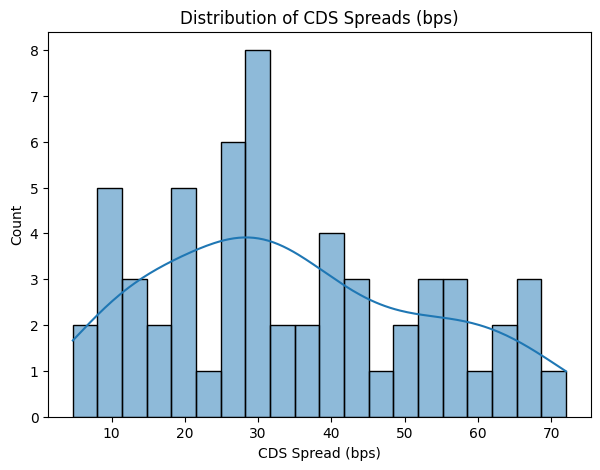

In [ ]:
# Basic summary of CDS and ESG
print("\nCDS Spread stats (bps):")
print(companies_df['CDS_Spread_5Y'].describe())
print("\nESG Score stats:")
print(companies_df['ESG_Score'].describe())

# Scatter plot CDS vs ESG
plt.figure(figsize=(7,5))
sns.scatterplot(data=companies_df, x='ESG_Score', y='CDS_Spread_5Y')
plt.title("CDS Spread (5Y) vs ESG Score")
plt.xlabel("ESG Score")
plt.ylabel("CDS Spread (bps)")
plt.show()

# Histogram of CDS spreads
plt.figure(figsize=(7,5))
sns.histplot(companies_df['CDS_Spread_5Y'], bins=20, kde=True)
plt.title("Distribution of CDS Spreads (bps)")
plt.xlabel("CDS Spread (bps)")
plt.show()

## Search for Outliers

In [ ]:
# Domain specific violations
print('Companies with too negative Debt to Equity:', sum(companies_df_clean['Debt_to_Equity'] < -1))
print('Companies with negative Total Assets:', sum(companies_df_clean['Total_Assets'] < 0))
print('Companies with too high CDS spread', sum(companies_df_clean['CDS_Spread_5Y'] > 5000))


Companies with too negative Debt to Equity: 0
Companies with negative Total Assets: 0
Companies with too high CDS spread 0


Outliers detected: 3 (6.00% of data)


,Sector,Region,ESG_Score,Carbon_Intensity,Total_Assets,Debt_to_Equity,EBITDA_Margin,Leverage_Ratio,CDS_Spread_5Y,Outlier,Outlier_Type
5,Technology,South America,39.3597,52.2993,195218.7117,1.9630,36.3433,1.0360,65.1008,True,"Low ESG, Low Carbon Intensity"
29,Consumer Goods,South America,32.7870,1038.9233,51050.7359,0.9174,9.0973,1.0939,13.4173,True,High Carbon Intensity
34,Healthcare,Europe,87.9379,494.0537,11108.5231,2.2317,7.9437,1.2102,18.9321,True,High Carbon Intensity



Summary statistics for non-outliers:


,ESG_Score,Carbon_Intensity,Total_Assets,Debt_to_Equity,EBITDA_Margin,Leverage_Ratio,CDS_Spread_5Y
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
mean,59.101588,186.874269,92931.178698,1.617949,23.029677,1.098374,34.150670
std,16.076769,73.619919,52597.970726,0.913452,10.961832,0.628772,18.809481
min,32.063300,51.265400,4849.910700,0.152800,5.379300,0.121600,4.720900
25%,47.501200,125.771500,53586.439750,0.792850,15.719200,0.575900,18.781550
50%,59.710600,201.607300,95886.418200,1.768900,22.683800,1.152300,29.887100
75%,71.522400,239.563900,130465.100550,2.434950,32.670950,1.770900,48.224450
max,88.194600,293.252600,192604.386100,2.972500,39.532400,1.986600,72.005700



Summary statistics for outliers:


,ESG_Score,Carbon_Intensity,Total_Assets,Debt_to_Equity,EBITDA_Margin,Leverage_Ratio,CDS_Spread_5Y
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,53.361533,528.425433,85792.656900,1.704033,17.794767,1.113367,32.483400
std,30.123810,494.209259,96847.257022,0.694366,16.073853,0.088717,28.381761
min,32.787000,52.299300,11108.523100,0.917400,7.943700,1.036000,13.417300
25%,36.073350,273.176500,31079.629500,1.440200,8.520500,1.064950,16.174700
50%,39.359700,494.053700,51050.735900,1.963000,9.097300,1.093900,18.932100
75%,63.648800,766.488500,123134.723800,2.097350,22.720300,1.152050,42.016450
max,87.937900,1038.923300,195218.711700,2.231700,36.343300,1.210200,65.100800


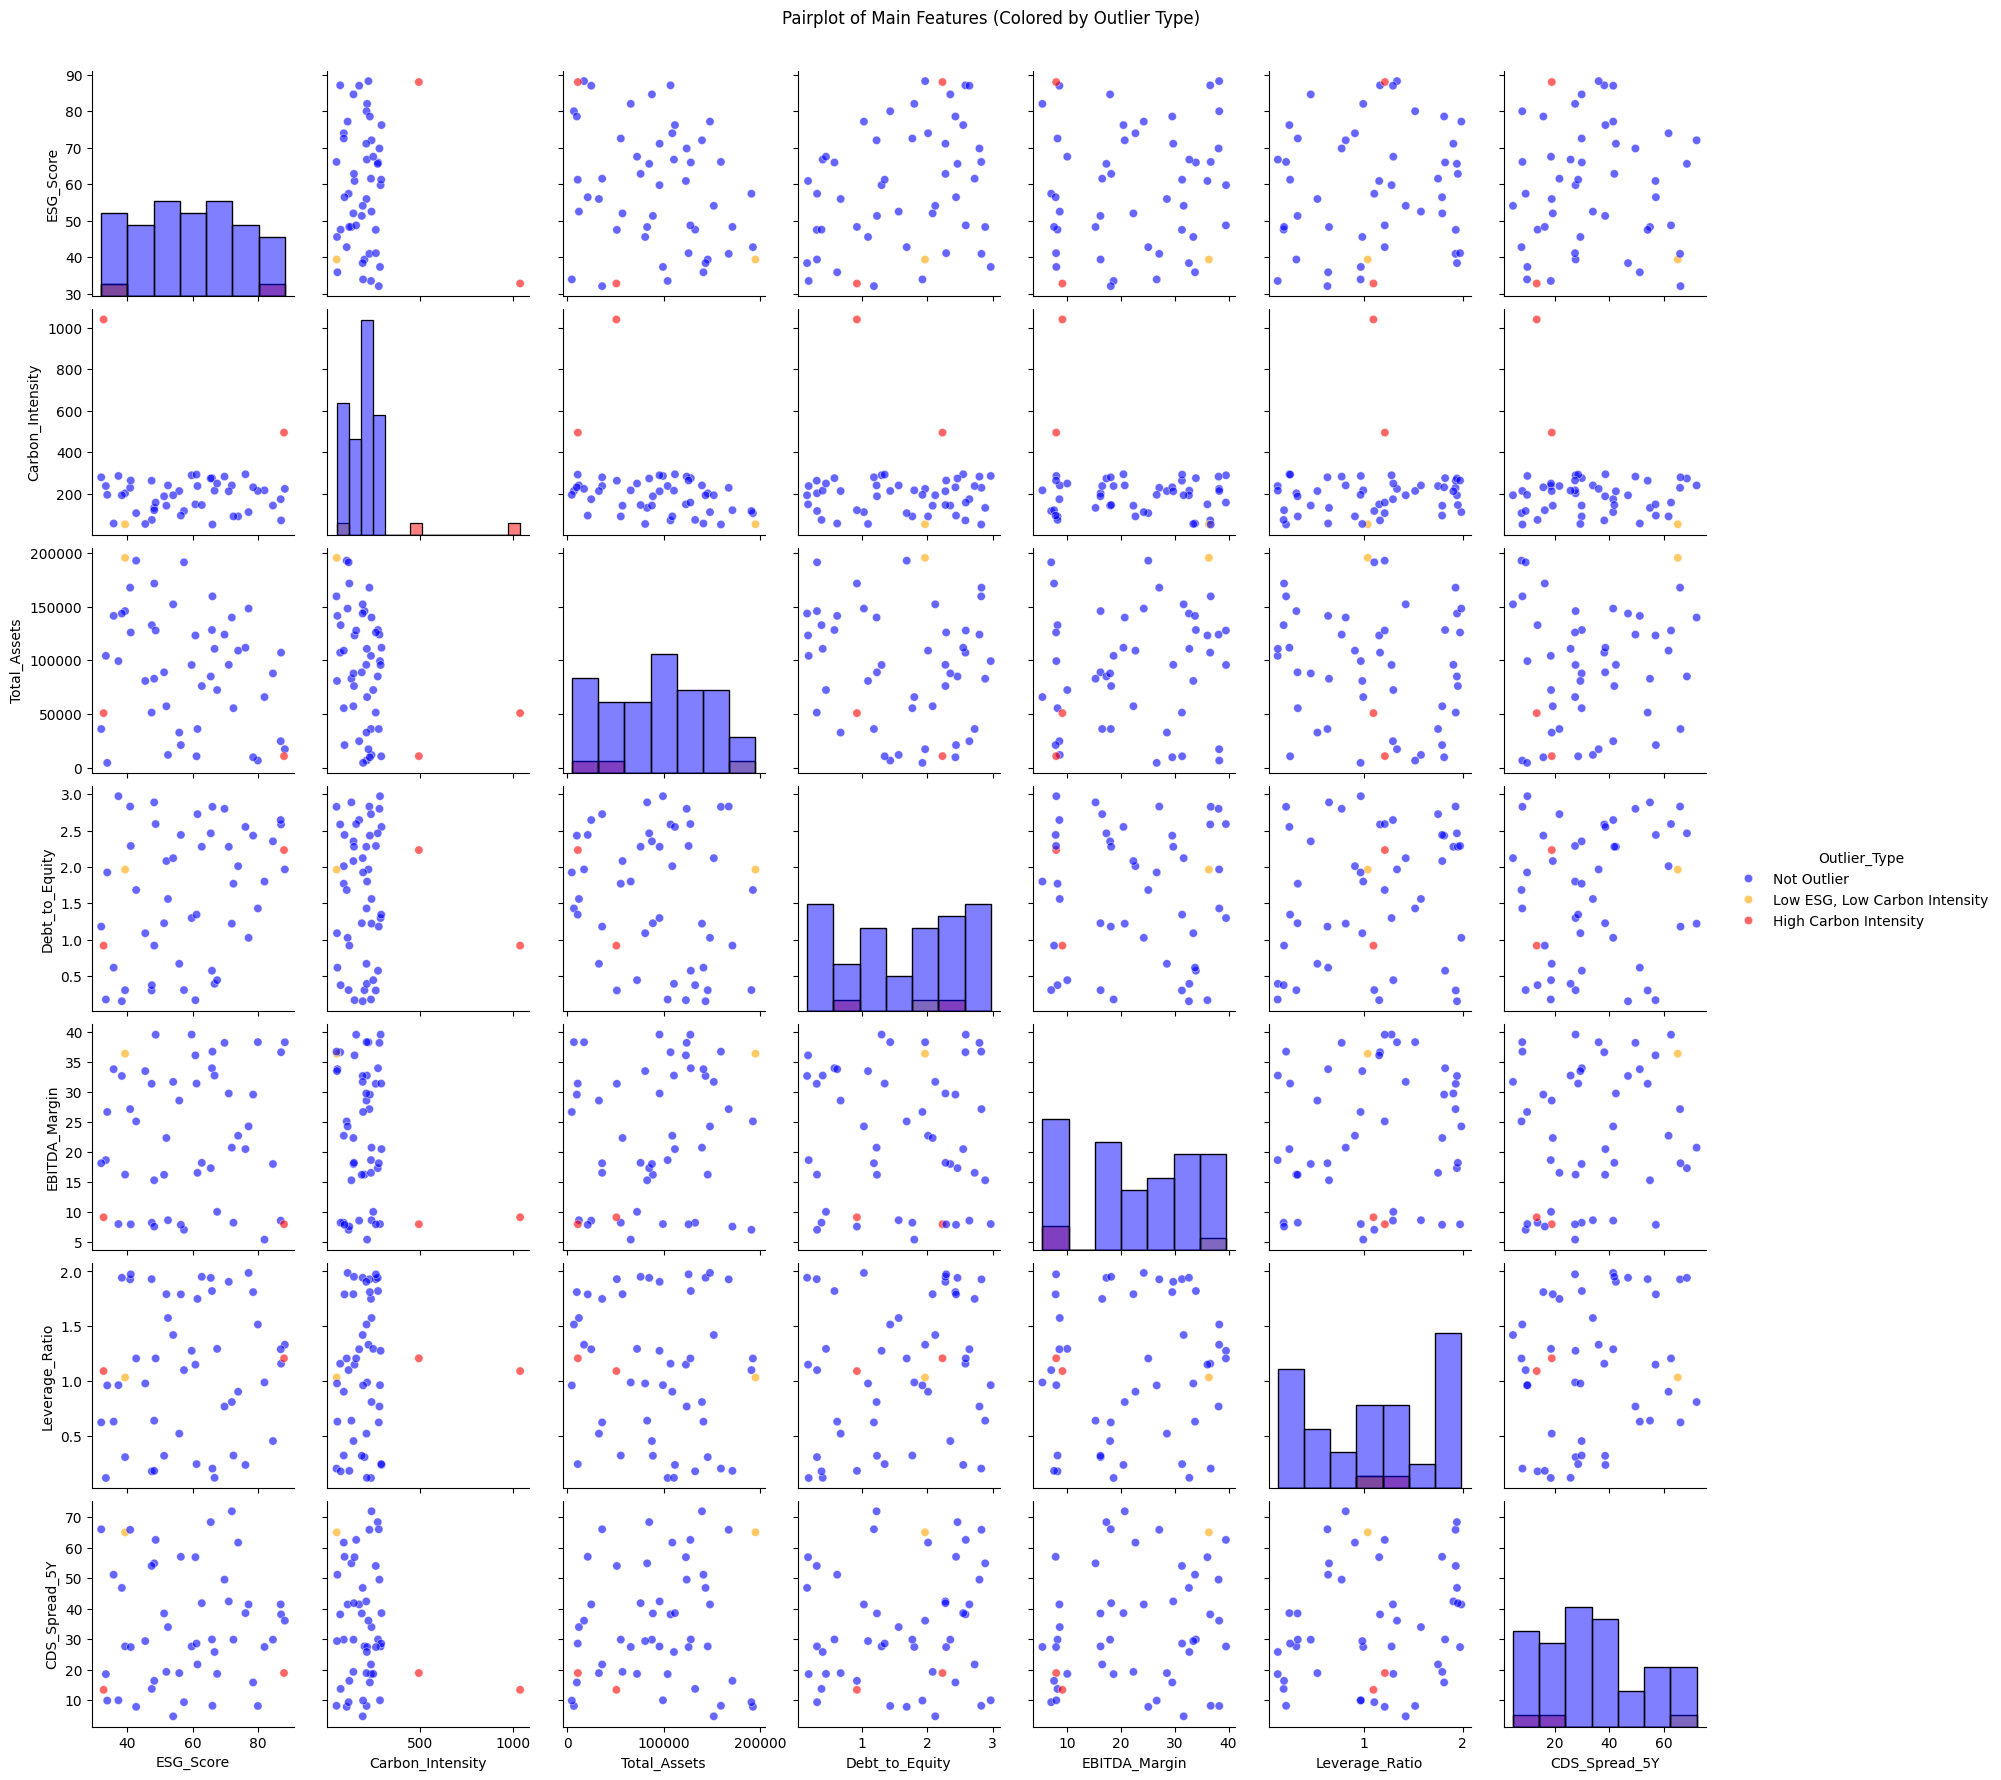

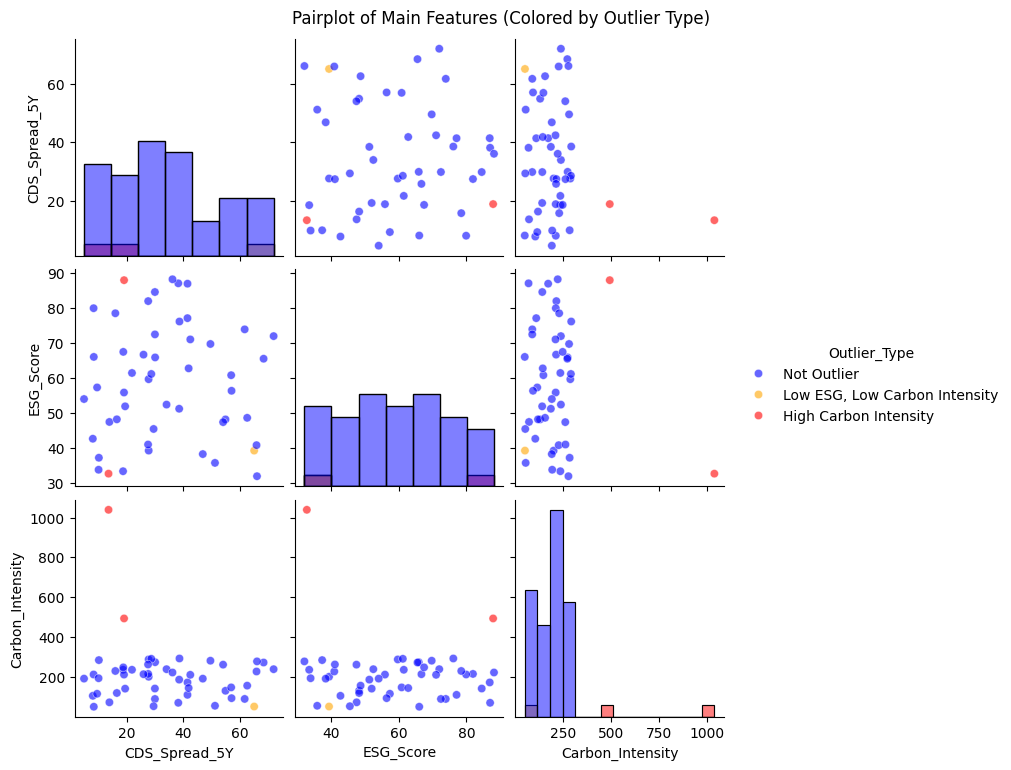

In [ ]:
# Select only numeric columns for outlier detection
X_num = companies_df_clean[companies_df_clean.columns.drop(['Sector','Region'])]

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=RANDOM_SEED)
outlier_pred = iso_forest.fit_predict(X_num)

# Add outlier flag to DataFrame
companies_df_clean['Outlier'] = (outlier_pred == -1)

# Categorize outliers based on characteristics
companies_df_clean['Outlier_Type'] = 'Not Outlier'
# Assuming the outliers identified are at indices 5, 29, and 34 based on previous output
# You might need to adjust these indices based on the actual outlier detection results
outlier_indices = companies_df_clean[companies_df_clean['Outlier']].index.tolist()

# Categorize outliers
if 29 in outlier_indices:
    companies_df_clean.loc[29, 'Outlier_Type'] = 'High Carbon Intensity'
if 34 in outlier_indices:
    companies_df_clean.loc[34, 'Outlier_Type'] = 'High Carbon Intensity'
if 5 in outlier_indices:
     companies_df_clean.loc[5, 'Outlier_Type'] = 'Low ESG, Low Carbon Intensity'

# Compare summary statistics and visualize outliers vs non-outliers
n_outliers = companies_df_clean['Outlier'].sum()
n_total = len(companies_df_clean)
print(f"Outliers detected: {n_outliers} ({n_outliers/n_total:.2%} of data)")
display(companies_df_clean[companies_df_clean['Outlier']])

print("\nSummary statistics for non-outliers:")
display(companies_df_clean[~companies_df_clean['Outlier']].describe())

print("\nSummary statistics for outliers:")
display(companies_df_clean[companies_df_clean['Outlier']].describe())

main_features = companies_df_clean.columns.drop(['Outlier','Outlier_Type', 'Sector','Region'])

sns.pairplot(companies_df_clean, vars=main_features, hue='Outlier_Type', palette={'Not Outlier': "blue", 'High Carbon Intensity': "red", 'Low ESG, Low Carbon Intensity': "orange"}, plot_kws={'alpha':0.6}, diag_kind='hist')
plt.suptitle("Pairplot of Main Features (Colored by Outlier Type)", y=1.02)
plt.show()

sns.pairplot(companies_df_clean, vars=['CDS_Spread_5Y', 'ESG_Score', 'Carbon_Intensity'], hue='Outlier_Type', palette={'Not Outlier': "blue", 'High Carbon Intensity': "red", 'Low ESG, Low Carbon Intensity': "orange"}, plot_kws={'alpha':0.6}, diag_kind='hist')
plt.suptitle("Pairplot of Main Features (Colored by Outlier Type)", y=1.02)
plt.show()

companies_df_clean = companies_df_clean.drop(['Outlier', 'Outlier_Type'], axis=1)

# **Baseline linear model**

## Utilities

In [ ]:
def evaluate_model(model, X, y, cv=5):
    # Fit on full dataset
    model.fit(X, y)
    y_pred_train = model.predict(X)
    train_rmse = np.sqrt(mean_squared_error(y, y_pred_train))
    train_r2   = r2_score(y, y_pred_train)

    # Fit with CV
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error")
    cv_rmse = np.sqrt(-cv_scores.mean())
    y_pred_cv = cross_val_predict(model, X, y, cv=cv)

    print(f"Train RMSE: {train_rmse:.2f}, R²: {train_r2:.2f}")
    print(f"CV RMSE: {cv_rmse:.2f}")

    plt.figure(figsize=(6,6))
    plt.scatter(y, y_pred_cv, alpha=0.5)
    plt.plot([min(y), max(y)], [min(y), max(y)], 'k--', lw=2)
    plt.xlabel("Actual CDS Spread (bps)")
    plt.ylabel("Predicted CDS Spread (bps)")
    plt.grid(True, alpha=0.5)
    plt.show()


## Trivial OLS

Train RMSE: 18.92, R²: 0.00
CV RMSE: 19.68


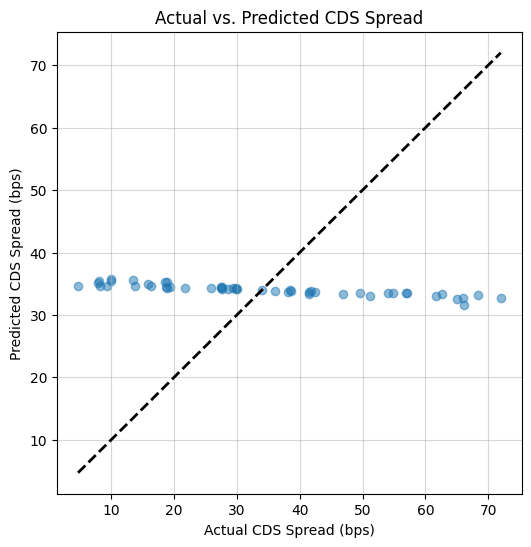

In [ ]:
# Regression with only ESG
X = companies_df_clean[['ESG_Score']].values
y = companies_df_clean['CDS_Spread_5Y'].values
cv = LeaveOneOut()

ols = make_pipeline(StandardScaler(), LinearRegression())
ols_results = evaluate_model(ols, X, y, cv=cv)

## Full OLS

Train RMSE: 16.88, R²: 0.20
CV RMSE: 24.75


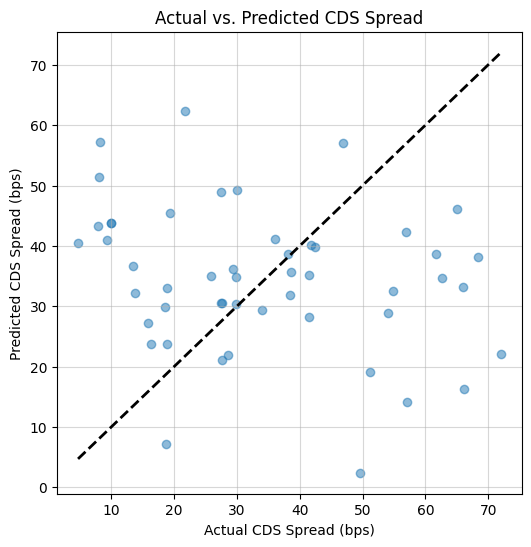

In [ ]:
# Full regression
X = companies_df_clean.drop(columns=['CDS_Spread_5Y'])
X = pd.get_dummies(X, columns=['Sector', 'Region'], drop_first=True).values
y = companies_df_clean['CDS_Spread_5Y'].values
cv = LeaveOneOut()

ols = make_pipeline(StandardScaler(), LinearRegression())
ols_results = evaluate_model(ols, X, y, cv=cv)


## **Lasso**

Best alpha: 11.1112
Train RMSE: 18.92, R²: 0.00
CV RMSE: 19.30


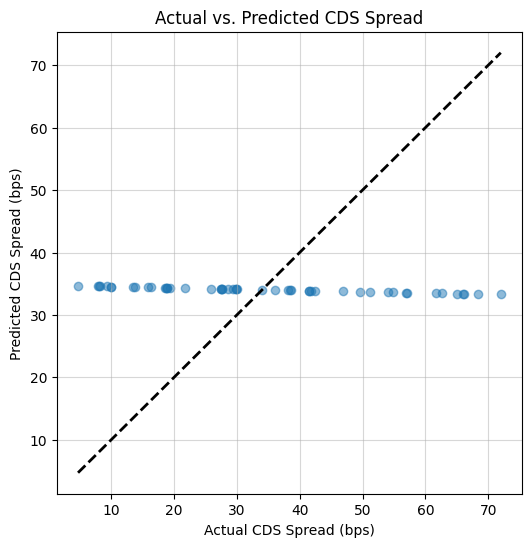

In [ ]:
from sklearn.model_selection import GridSearchCV

X = companies_df_clean.drop(columns=['CDS_Spread_5Y'])
X = pd.get_dummies(X, columns=['Sector', 'Region'], drop_first=True).values
y = companies_df_clean['CDS_Spread_5Y'].values
cv = LeaveOneOut()

lasso_pipeline = make_pipeline(StandardScaler(), Lasso())

param_grid = {'lasso__alpha': np.linspace(1e-4, 100, 10)}

grid_search = GridSearchCV(
    lasso_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='neg_mean_squared_error',
)

grid_search.fit(X, y)

print("Best alpha:", grid_search.best_params_['lasso__alpha'])

# Evaluate the best estimator from grid search
grid_search_results = evaluate_model(grid_search.best_estimator_, X, y, cv=cv)

## Feature Selection with sequential selection

In [ ]:
X = companies_df_clean.drop(columns=['CDS_Spread_5Y'])
X = pd.get_dummies(X, columns=['Sector', 'Region'], drop_first=True)
y = companies_df_clean['CDS_Spread_5Y'].values

estimator = make_pipeline(StandardScaler(), LinearRegression())
cv = LeaveOneOut()

# Forward stepwise selection
sfs_forward = SFS(
    estimator,
    k_features="best",
    forward=True,
    floating=False,
    scoring='neg_mean_squared_error',
    cv=cv,
)

sfs_forward = sfs_forward.fit(X, y)

print("Forward-selected features:", sfs_forward.k_feature_names_)

# Backward stepwise selection
sfs_backward = SFS(
    estimator,
    k_features="best",
    forward=False,
    floating=False,
    scoring='neg_mean_squared_error',
    cv=cv,
)

sfs_backward = sfs_backward.fit(X, y)

print("Backward-selected features:", sfs_backward.k_feature_names_)


Forward-selected features: ('Carbon_Intensity', 'Leverage_Ratio', 'Sector_Energy')
Backward-selected features: ('Carbon_Intensity', 'Leverage_Ratio', 'Sector_Energy')


Train RMSE: 17.87, R²: 0.11
CV RMSE: 18.74


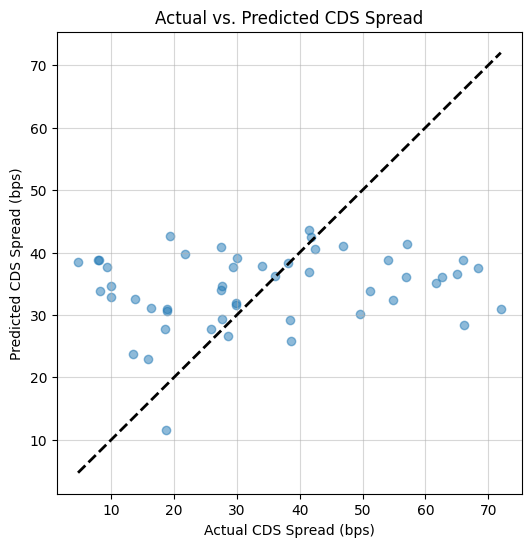

Train RMSE: 17.87, R²: 0.11
CV RMSE: 18.74


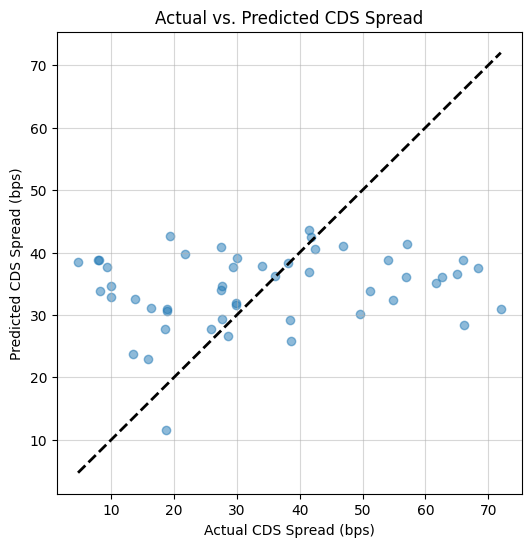

In [ ]:
X = companies_df_clean.drop(columns=['CDS_Spread_5Y'])
X = pd.get_dummies(X, columns=['Sector', 'Region'], drop_first=True)
X_forward = X[list(sfs_forward.k_feature_names_)]
X_backward = X[list(sfs_backward.k_feature_names_)]
y = companies_df_clean['CDS_Spread_5Y'].values
cv = LeaveOneOut()

ols_forward = make_pipeline(StandardScaler(), LinearRegression())
ols_results_forward = evaluate_model(ols_forward, X_forward, y, cv=cv)

ols_backward = make_pipeline(StandardScaler(), LinearRegression())
ols_results_backward = evaluate_model(ols_backward, X_backward, y, cv=cv)

## Feature Selection with correlation

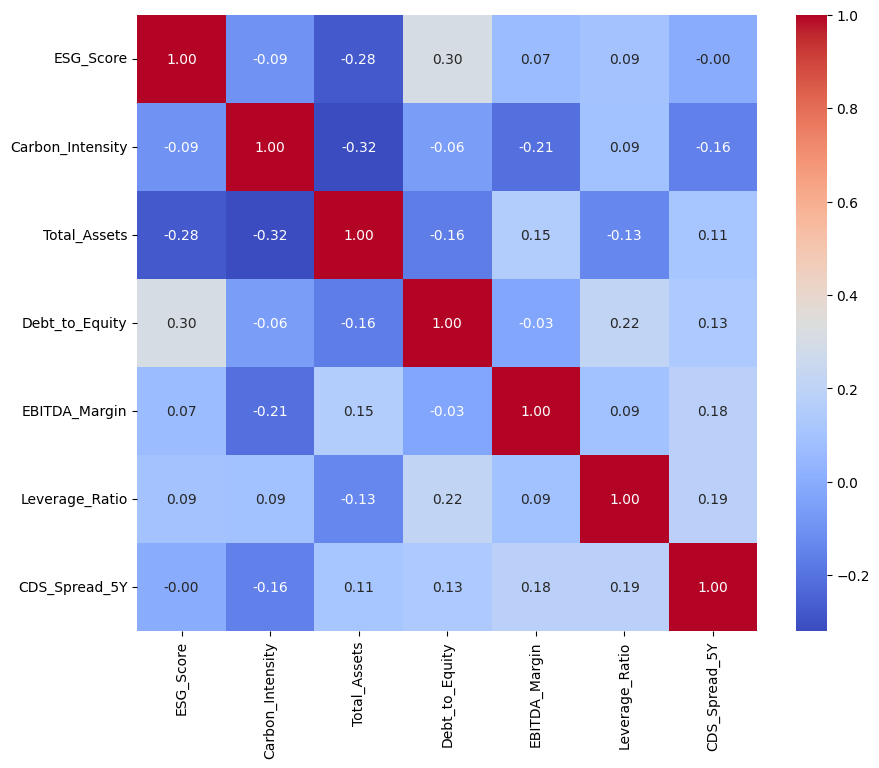

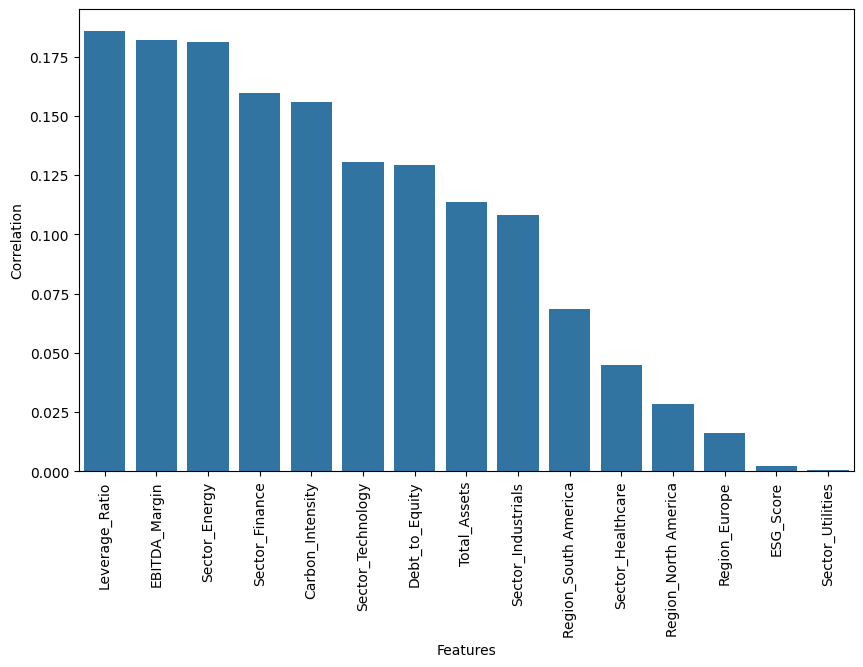

Train RMSE: 17.92, R²: 0.10
CV RMSE: 19.39


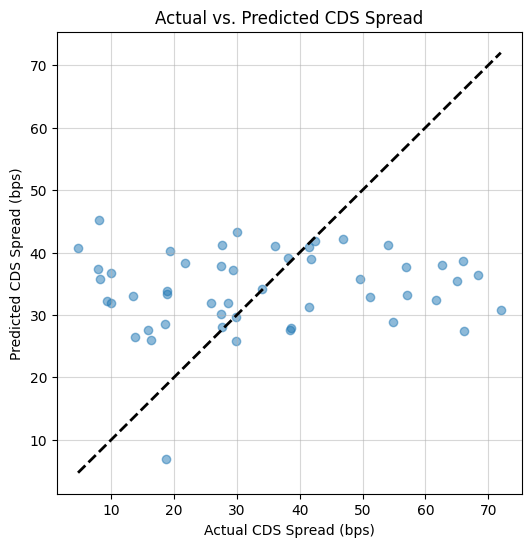

In [ ]:
# Top N correlated features + ESG
N = 3
X = companies_df_clean

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(X.drop(columns=['Sector','Region']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

X = pd.get_dummies(X, columns=['Sector', 'Region'], drop_first=True)
corr = X.corr()

corr = np.abs(corr['CDS_Spread_5Y']).sort_values(ascending=False)[1:]

# Plot correlation
plt.figure(figsize=(10, 6))
sns.barplot(x=corr.index, y=corr.values)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.show()

features = [corr.index[i] for i in range(N)]
if 'ESG_Score' not in features:
    features.append('ESG_Score')
X = X[features].values
y = companies_df_clean['CDS_Spread_5Y'].values
cv = LeaveOneOut()

ols = make_pipeline(StandardScaler(), LinearRegression())
ols_results = evaluate_model(ols, X, y, cv=cv)

# **Machine learning models**

## Random Forest

Train RMSE: 7.52, R²: 0.84
CV RMSE: 20.44


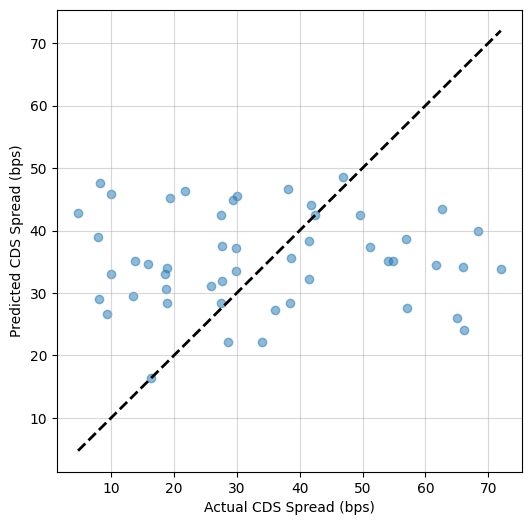

In [ ]:
# Random Forest
X = companies_df_clean.drop(columns=['CDS_Spread_5Y'])
X = pd.get_dummies(X, columns=['Sector', 'Region'], drop_first=True).values
y = companies_df_clean['CDS_Spread_5Y'].values
cv = LeaveOneOut()

rf = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=RANDOM_SEED))
rf_results = evaluate_model(rf, X, y, cv=cv)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found: {'randomforestregressor__max_depth': 5, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 3, 'randomforestregressor__n_estimators': 152}

Evaluating best model:
Train RMSE: 9.01, R²: 0.77
CV RMSE: 19.68


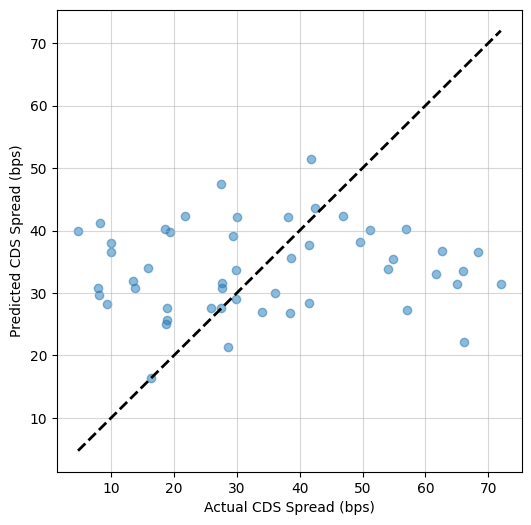

In [ ]:
# Features and target
X = companies_df_clean.drop(columns=['CDS_Spread_5Y'])
X = pd.get_dummies(X, columns=['Sector', 'Region'], drop_first=True).values
y = companies_df_clean['CDS_Spread_5Y'].values
cv = 5

rf = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=RANDOM_SEED))

param_dist = {
    'randomforestregressor__n_estimators': randint(100, 500),
    'randomforestregressor__max_depth': [None, 5, 10, 20],
    'randomforestregressor__min_samples_split': randint(2, 10),
    'randomforestregressor__min_samples_leaf': randint(1, 5)
}

rand_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_SEED,
    verbose=1
)

rand_search.fit(X, y)

print("Best parameters found:", rand_search.best_params_)

# Evaluate the best model
print("\nEvaluating best model:")
evaluate_model(rand_search.best_estimator_, X, y, cv=cv)

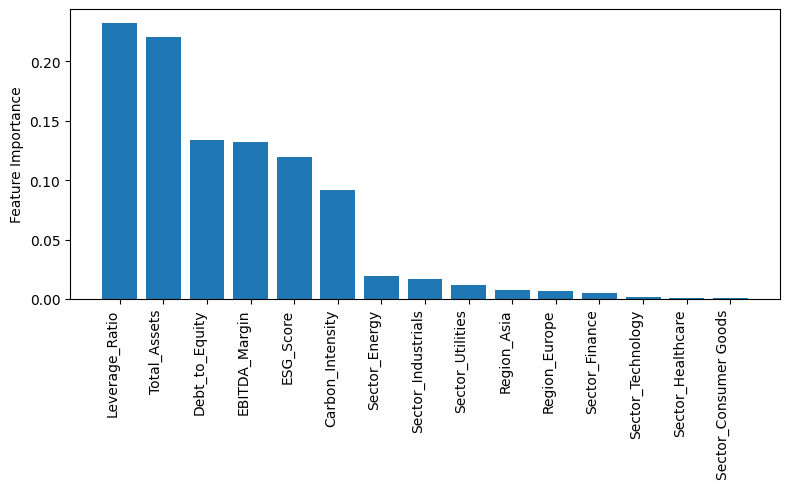

In [ ]:
# Importanza delle feature
importances = rand_search.best_estimator_.steps[1][1].feature_importances_
feature_names = companies_df_clean.drop(columns=['CDS_Spread_5Y'])
feature_names = pd.get_dummies(feature_names, columns=['Sector', 'Region']).columns.tolist()

# Ordinamento decrescente
indices = importances.argsort()[::-1]

# Plot
plt.figure(figsize=(8,5))
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90, ha="right")
plt.ylabel("Feature Importance")
#plt.title("Importanza delle feature - Random Forest")
plt.tight_layout()
plt.show()

## Random Forest with sequential selection

In [ ]:
X = companies_df_clean.drop(columns=['CDS_Spread_5Y'])
X = pd.get_dummies(X, columns=['Sector', 'Region'], drop_first=True)
y = companies_df_clean['CDS_Spread_5Y'].values

estimator = make_pipeline(StandardScaler(), RandomForestRegressor())
cv = LeaveOneOut()

# Forward stepwise selection
sfs_forward = SFS(
    estimator,
    k_features="best",
    forward=True,
    floating=False,
    scoring='neg_mean_squared_error',
    cv=5,
)

sfs_forward = sfs_forward.fit(X, y)

print("Forward-selected features:", sfs_forward.k_feature_names_)

# Backward stepwise selection
sfs_backward = SFS(
    estimator,
    k_features="best",
    forward=False,
    floating=False,
    scoring='neg_mean_squared_error',
    cv=5,
)

sfs_backward = sfs_backward.fit(X, y)

print("Backward-selected features:", sfs_backward.k_feature_names_)


Forward-selected features: ('EBITDA_Margin', 'Leverage_Ratio', 'Sector_Energy', 'Sector_Finance', 'Sector_Healthcare', 'Sector_Industrials')
Backward-selected features: ('EBITDA_Margin', 'Leverage_Ratio', 'Sector_Energy')


Train RMSE: 6.44, R²: 0.88
CV RMSE: 18.03


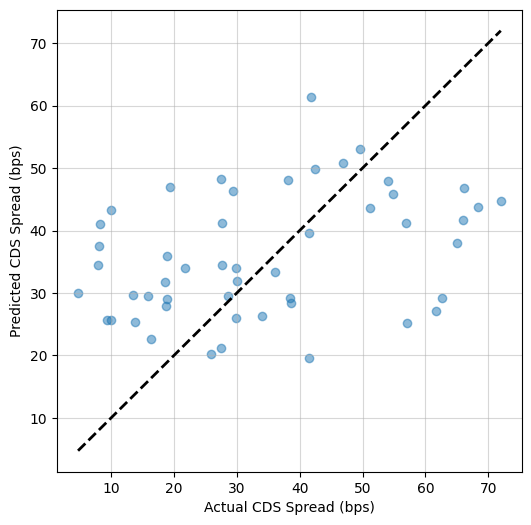

Train RMSE: 6.27, R²: 0.89
CV RMSE: 17.10


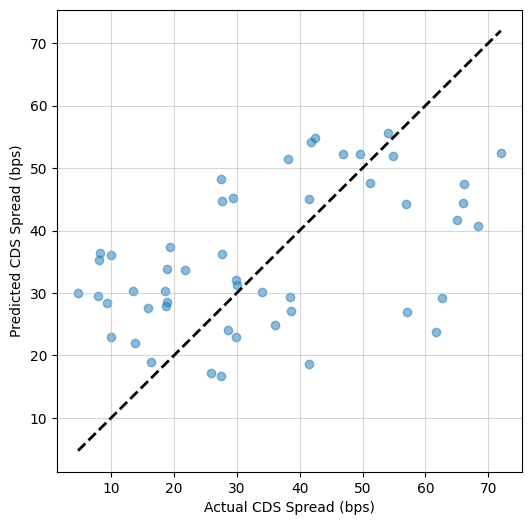

In [ ]:
X = companies_df_clean.drop(columns=['CDS_Spread_5Y'])
X = pd.get_dummies(X, columns=['Sector', 'Region'], drop_first=True)
X_forward = X[list(sfs_forward.k_feature_names_)]
X_backward = X[list(sfs_backward.k_feature_names_)]
y = companies_df_clean['CDS_Spread_5Y'].values
cv = LeaveOneOut()

ols_forward = make_pipeline(StandardScaler(), RandomForestRegressor())
ols_results_forward = evaluate_model(ols_forward, X_forward, y, cv=cv)

ols_backward = make_pipeline(StandardScaler(), RandomForestRegressor())
ols_results_backward = evaluate_model(ols_backward, X_backward, y, cv=cv)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Forward Selection - Best parameters found: {'randomforestregressor__max_depth': 10, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__min_samples_split': 4, 'randomforestregressor__n_estimators': 314}
Forward Selection - Best CV score (neg MSE): -312.21736566284216
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Backward Selection - Best parameters found: {'randomforestregressor__max_depth': 10, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__min_samples_split': 4, 'randomforestregressor__n_estimators': 314}
Backward Selection - Best CV score (neg MSE): -303.94543423517445

Evaluating best models:
Forward Selection Model:
Train RMSE: 9.09, R²: 0.77
CV RMSE: 17.48


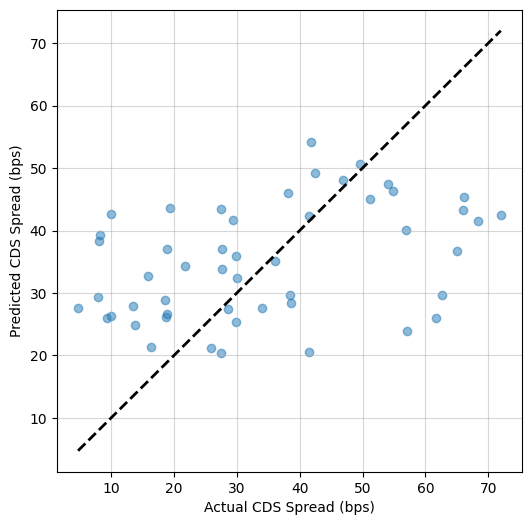


Backward Selection Model:
Train RMSE: 8.86, R²: 0.78
CV RMSE: 16.76


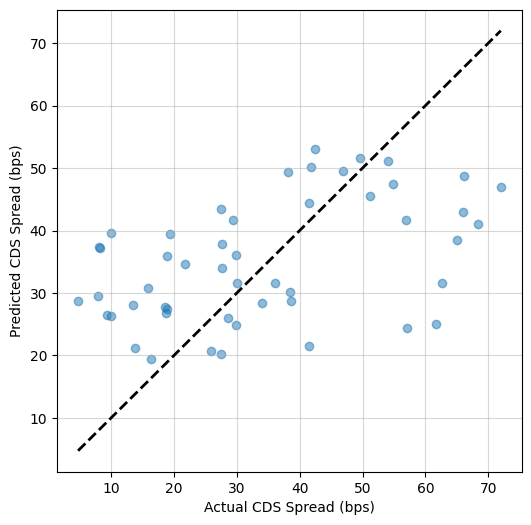

In [ ]:
# Features and target
X = companies_df_clean.drop(columns=['CDS_Spread_5Y'])
X = pd.get_dummies(X, columns=['Sector', 'Region'], drop_first=True)
X_forward = X[list(sfs_forward.k_feature_names_)]
X_backward = X[list(sfs_backward.k_feature_names_)]
y = companies_df_clean['CDS_Spread_5Y'].values
cv = 5

# Random Forest with forward selected features
rf_forward = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=RANDOM_SEED))

param_dist = {
    'randomforestregressor__n_estimators': randint(100, 500),
    'randomforestregressor__max_depth': [None, 5, 10, 20],
    'randomforestregressor__min_samples_split': randint(2, 10),
    'randomforestregressor__min_samples_leaf': randint(1, 5)
}

rand_search_forward = RandomizedSearchCV(
    rf_forward,
    param_distributions=param_dist,
    n_iter=20,
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_SEED,
    verbose=1
)

rand_search_forward.fit(X_forward, y)

print("Forward Selection - Best parameters found:", rand_search_forward.best_params_)

# Random Forest with backward selected features
rf_backward = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=RANDOM_SEED))

rand_search_backward = RandomizedSearchCV(
    rf_backward,
    param_distributions=param_dist,
    n_iter=20,
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_SEED,
    verbose=1
)

rand_search_backward.fit(X_backward, y)

print("\nBackward Selection - Best parameters found:", rand_search_backward.best_params_)

# Evaluate the best models
print("\nEvaluating best models:")
print("Forward Selection Model:")
evaluate_model(rand_search_forward.best_estimator_, X_forward, y, cv=LeaveOneOut())

print("\nBackward Selection Model:")
evaluate_model(rand_search_backward.best_estimator_, X_backward, y, cv=LeaveOneOut())

# **CVA computation and Model interpretability**

## Interpolate Zero Rates

In [ ]:
# Convert zero rates to float
maturities = zeros_df['Maturity'].values
zero_rates = zeros_df['Zero_Rate'].str.rstrip('%').astype(float) / 100

# Interpolate at x.5 years
additional_maturities = np.arange(1.5, 5.5, 1) # Changed upper bound to include 5.0
interpolated_zero_rates = np.interp(additional_maturities, maturities, zero_rates)

# Combine original and interpolated rates
all_maturities = np.concatenate([maturities, additional_maturities])
all_zero_rates = np.concatenate([zero_rates, interpolated_zero_rates])

# Sort by maturity
sort_indices = np.argsort(all_maturities)
all_maturities_sorted = all_maturities[sort_indices]
all_zero_rates_sorted = all_zero_rates[sort_indices]

# Create a new DataFrame with the combined rates
zeros_df_clean = pd.DataFrame({
    'Maturity': all_maturities_sorted,
    'Zero_Rate': all_zero_rates_sorted
})

print("\nInterpolated Zero Rates:")
display(zeros_df_clean)

maturities = zeros_df_clean['Maturity'].values
zero_rates = zeros_df_clean['Zero_Rate'].values


Interpolated Zero Rates:


,Maturity,Zero_Rate
0,0.5,0.02000
1,1.0,0.02050
2,1.5,0.02075
3,2.0,0.02100
4,2.5,0.02125
5,3.0,0.02150
6,3.5,0.02175
7,4.0,0.02200
8,4.5,0.02225
9,5.0,0.02250


## Compute CVA

In [ ]:
def compute_cva(cds_spreads, discount_factors, expected_exposure, maturities, lgd=LGD):

    cds_spreads = cds_spreads
    cvas = []
    for cds in cds_spreads:
        cds = cds / 10000
        hazard_rate = cds / lgd
        survival_probs = np.exp(-hazard_rate * maturities)
        survival_probs = np.concatenate([[1], survival_probs])
        default_probs = survival_probs[:-1] - survival_probs[1:]
        cva = np.sum(discount_factors * expected_exposure * default_probs * lgd)
        cvas.append(cva)
    return np.array(cvas)

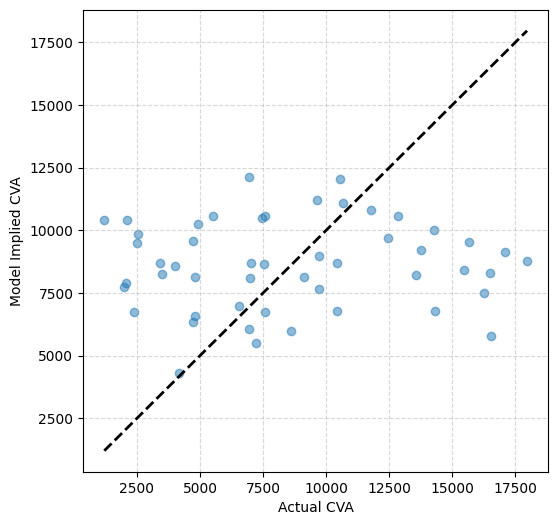

In [ ]:
# Common parameters
maturities = zeros_df_clean['Maturity']
zero_rates = zeros_df_clean['Zero_Rate']
discount_factors = np.exp(-zero_rates * maturities)
expected_exposure = ee_df['EE']

# Actual CVA
CDS_actual = companies_df_clean['CDS_Spread_5Y']
CVA_actual = compute_cva(CDS_actual, discount_factors, expected_exposure, maturities)

# Model implied CVA
CDS_model = cross_val_predict(rand_search_backward.best_estimator_, X, y, cv=cv)
CVA_model = compute_cva(CDS_model, discount_factors, expected_exposure, maturities)

# Plot CVAs
plt.figure(figsize=(6,6))
plt.scatter(CVA_actual, CVA_model, alpha=0.5)
plt.plot([min(CVA_actual), max(CVA_actual)], [min(CVA_actual), max(CVA_actual)], 'k--', lw=2)
plt.xlabel("Actual CVA")
plt.ylabel("Model Implied CVA")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

## Compute Green Premimum

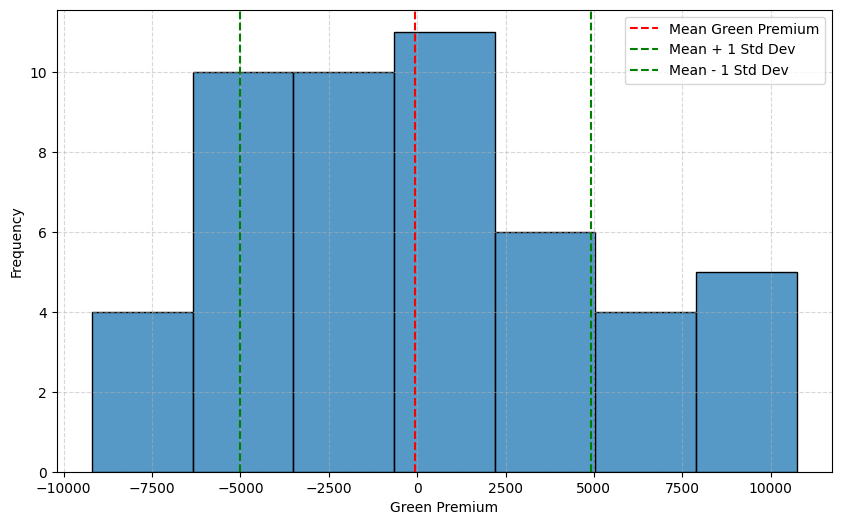

/tmp/ipython-input-113552193.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_green_premium_by_tertile = companies_df_clean.groupby('ESG_tertile')['Green_Premium'].mean()
/tmp/ipython-input-113552193.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for tertile, group in companies_df_clean.groupby('ESG_tertile'):


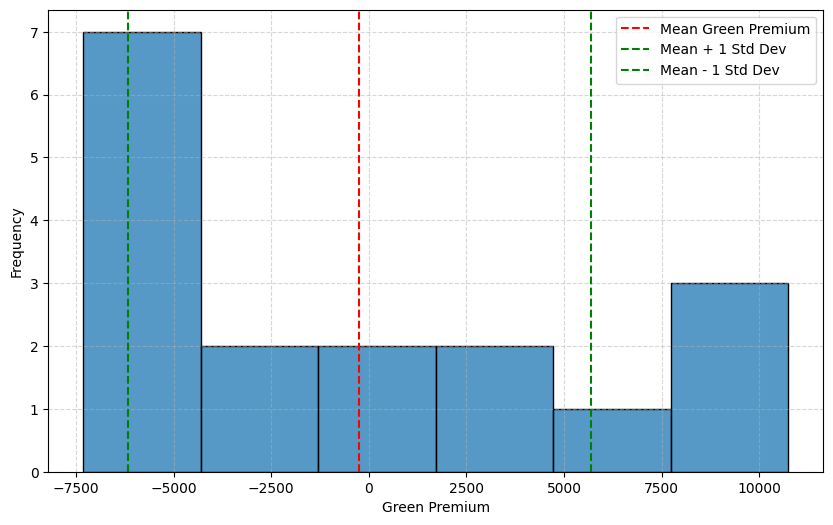

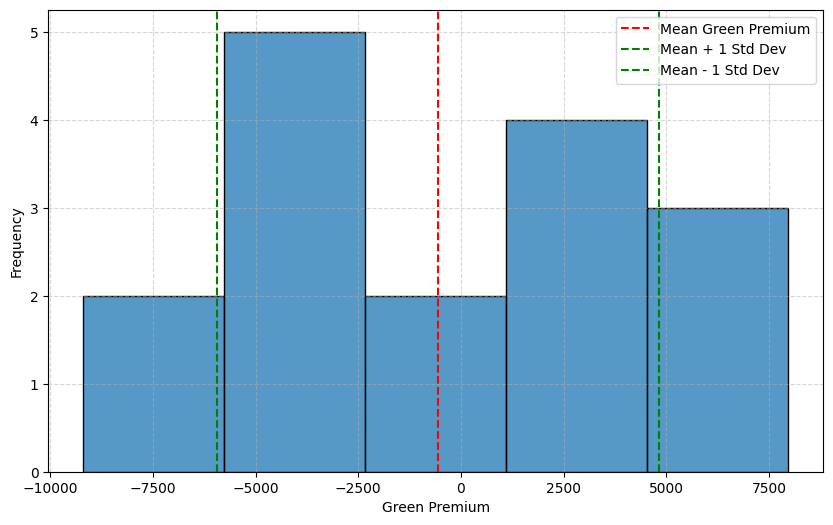

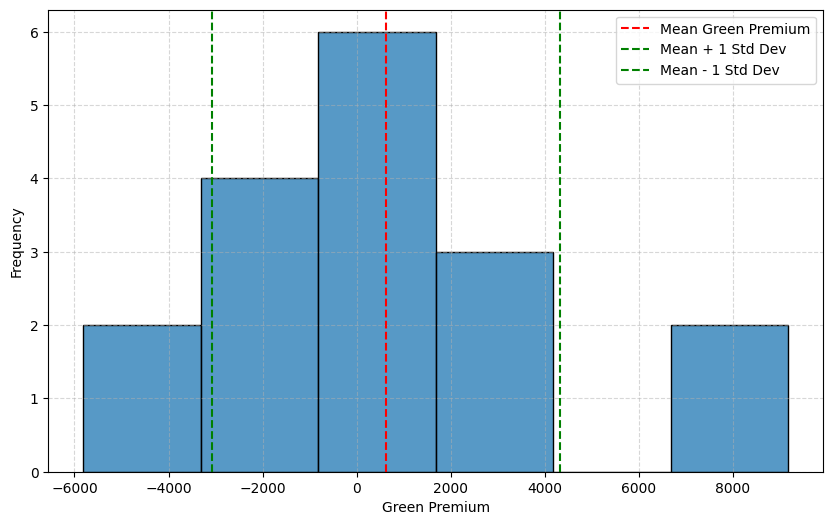

In [ ]:
# Compute green premimum
green_prem = CVA_actual - CVA_model
plt.figure(figsize=(10, 6))
sns.histplot(green_prem, kde=False)
plt.axvline(green_prem.mean(), color='r', linestyle='--', label='Mean Green Premium') #
plt.axvline(green_prem.mean() + green_prem.std(), color='g', linestyle='--', label='Mean + 1 Std Dev')
plt.axvline(green_prem.mean() - green_prem.std(), color='g', linestyle='--', label='Mean - 1 Std Dev')
plt.xlabel('Green Premium')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# ESG tertile bucket
companies_df_clean['Green_Premium'] = green_prem
companies_df_clean['ESG_tertile'] = pd.qcut(companies_df_clean['ESG_Score'], 3, labels=['Low', 'Medium', 'High'])

# Calculate mean green premium by ESG tertile
mean_green_premium_by_tertile = companies_df_clean.groupby('ESG_tertile')['Green_Premium'].mean()

# Plot green premimum distribution by ESG tertile
for tertile, group in companies_df_clean.groupby('ESG_tertile'):
    plt.figure(figsize=(10, 6))
    sns.histplot(group['Green_Premium'], kde=False)
    plt.axvline(group['Green_Premium'].mean(), color='r', linestyle='--', label='Mean Green Premium')
    plt.axvline(group['Green_Premium'].mean() + group['Green_Premium'].std(), color='g', linestyle='--', label='Mean + 1 Std Dev')
    plt.axvline(group['Green_Premium'].mean() - group['Green_Premium'].std(), color='g', linestyle='--', label='Mean - 1 Std Dev')
    plt.xlabel('Green Premium')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

# Table of results


In [ ]:
table = pd.DataFrame({
    "CDS_actual": CDS_actual,
    "CVA_actual": CVA_actual,
    "CDS_model":  CDS_model,
    "CVA_model":  CVA_model,
})
display( table)


NameError: name 'pd' is not defined